In [11]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.conn import conn_reshape_undirected
# Import plot functions from current repo
import sys
sys.path.append('../')
from plot.plot_marsatlas import plot_marsatlas
from plot.plot_fcd import plot_fcd_circular_xr
import matplotlib.gridspec as gridspec

## Figure 2. Local spatio-temporal correlates of information gain

In [12]:
# Load GCMI data
Results_Dir = '/home/INT/brovelli.a/code/hosi_infogain/data/'
fname = Results_Dir + 'outcome_infogain_gcmi.nc'
data = xr.load_dataset(fname)

# Stats params
threshold = 0.05
title = 'Outcome Information Gain' + ' p<' + str(threshold)

# Prepare data for plotting
gcmi = data['mi']
gcmi_tval = data['tval']
pvalues = data['pv']
allroi = data.roi
nroi = len(allroi)
times = data.times

    Load MarsAtlas labels
    Consider p-values < 0.05


/home/INT/brovelli.a/code/hosi_infogain/notebooks/../plot/plot_marsatlas.py:135: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('L', 'Subcortical')] = np.nan
/home/INT/brovelli.a/code/hosi_infogain/notebooks/../plot/plot_marsatlas.py:136: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('R', 'Subcortical')] = np.nan
    Time selection between (-0.10, 1.00)
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


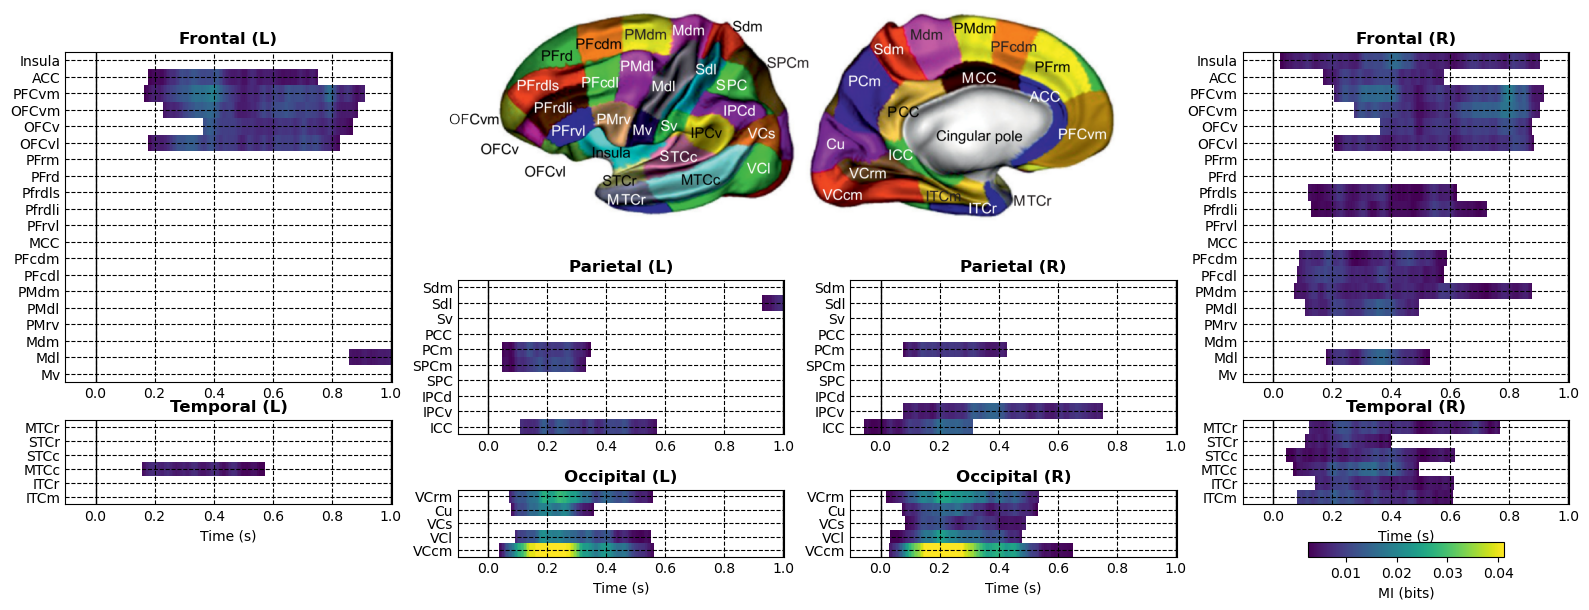

In [13]:
# Plot cluster-based gcmi on MarsAtlas
title = ''
vlines = {0.: dict(color='k', linewidth=1, linestyle='-'), 1.: dict(color='k', linewidth=1, linestyle='-')}
f = plot_marsatlas(gcmi, pvalues=pvalues, threshold=threshold, time=(-0.1, 1.),
               subcortical=False, contrast=1, cmap='viridis', title=title,
               cblabel='MI (bits)', vlines=vlines, grid=True)
# Add MarsAtlas
fname = Results_Dir + 'marsatlas.png'
marsatlas = plt.imread(fname)
newax = f.add_axes([0.29, 0.54, 0.45, 0.45])
# chage size of f to 16 x 8
f.set_size_inches(16, 6)
newax.imshow(marsatlas)
newax.axis('off')

plt.show()

In [19]:
# f.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_2.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_7851/4228138855.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_2.png', dpi=300, bbox_inches='tight')


## Correlations between Information Gain and RPE, Uncertainties


In [27]:
# Load data
fname = Results_Dir + 'outcome_infogain_pairwise_redundancy.nc'
ds = xr.load_dataset(fname)
# Thresholded data
da = ds.fredc * (ds.pv <= 0.05)
# Rename dim links
da = da.rename({'links': 'roi'})
# Select time interval
da = da.sel(times=slice(-0.1, 1.))
# Red 
red = da
# Load data
fname = Results_Dir + 'outcome_infogain_pairwise_synergy.nc'
ds = xr.load_dataset(fname)
# Thresholded data
da = ds.fsync * (ds.pv <= 0.05)
# Rename dim links
da = da.rename({'links': 'roi'})
# Select time interval
da = da.sel(times=slice(-0.1, 1.))
# Syn 
syn = da
# Take abs to remove potential -ve values due to bias correction
red = np.abs(red)
syn = np.abs(syn)

/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/INT/brovelli.a/code/hosi_infogain/plot/plot_fcd.py:380: UserWarning: rename 'sources' to 'sources' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({source_name: 'sources', target_name: 'targets'})
/home/INT/brovelli.a/code/hosi_infogain/plot/plot_fcd.py:380: UserWarning: rename 'targets' to 'targets' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  da = da.rename({source_name: 'sources', target_name: 'targets'})
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: un

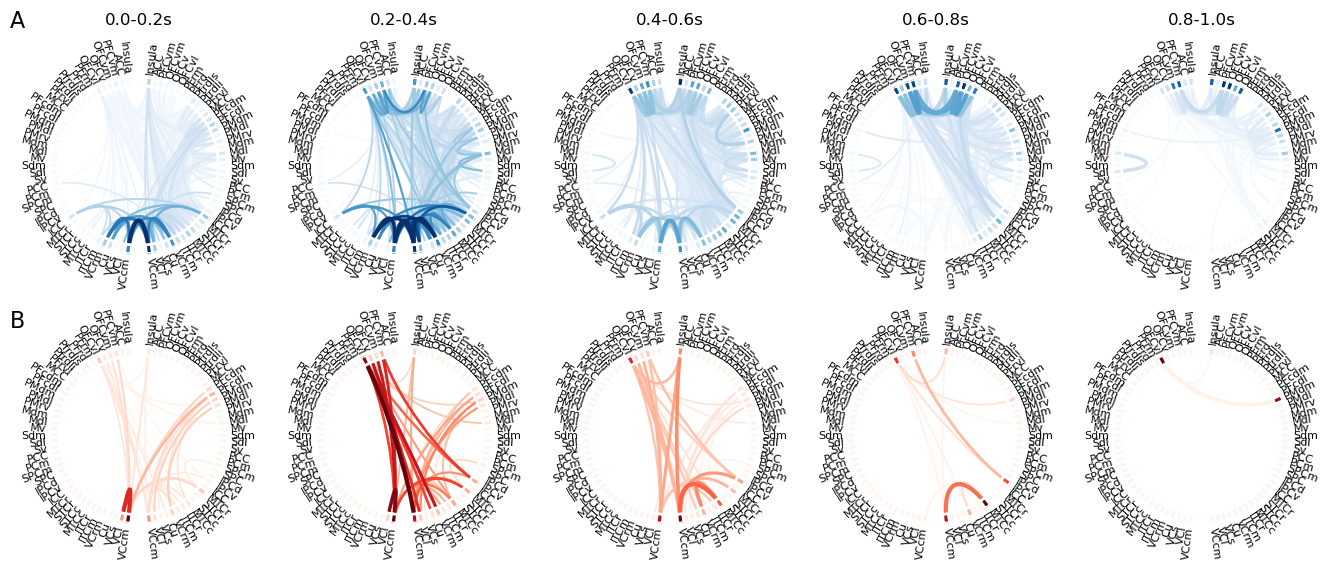

In [28]:
# Subplot per area
f, axs = plt.subplots(2, 5, figsize=(16, 6))
axs = np.ravel(axs)
# Add space horizontally between subplots
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.4)

# Time intervals
dt = 0.2
tc = np.arange(0.1, 0.95, 0.2)

i = 0
for t in tc:
    # Select time interval
    da = red.sel(times=slice(t-dt/2, t+dt/2))
    # Avergage over time
    da = da.mean(dim='times')
    # Create adj conn matrix
    da = conn_reshape_undirected(da, sep='-', order=None, rm_missing=False,
                                 fill_value=np.nan, to_dataframe=False,
                                 inplace=False, verbose=None)
    # Squeeze time axis
    da = da.squeeze()

    # Plot circular
    # plt.sca(axs[i])
    subplot_title = str(np.round((t-dt/2)*100)/100) + '-' + str(np.round((t+dt/2)*100)/100) + 's'

    plot_fcd_circular_xr(da.where(da > 0.), node_color='weight', colorbar=False, vmax=0.015, cmap='Blues',
                         cmap_node='Blues', lobes=['Frontal', 'Parietal', 'Occipital', 'Temporal'],
                         fig=f, subplot=(2,5,i+1), title=subplot_title)
   
    # Reduce the font of the title
    plt.title(subplot_title, fontsize=12, fontweight='bold')
    # move the title up a bit
    plt.title(subplot_title, y=1.25)
    
    i += 1

for t in tc:

    # Select time interval
    # da = red.sel(times=slice(start, start + dt))
    da = syn.sel(times=slice(t-dt/2, t+dt/2))

    # Avergage over time
    da = da.mean(dim='times')

    # Create adj conn matrix
    da = conn_reshape_undirected(da, sep='-', order=None, rm_missing=False,
                                 fill_value=np.nan, to_dataframe=False,
                                 inplace=False, verbose=None)
                             
    # Squeeze time axis
    da = da.squeeze()

    # Plot abs values
    da = np.abs(da)
    
    plot_fcd_circular_xr(da.where(da > 0.), node_color='weight', vmax=0.006, colorbar=False, cmap='Reds',
                        cmap_node='Reds', lobes=['Frontal', 'Parietal', 'Occipital', 'Temporal'],
                        fig=f, subplot=(2,5,i+1))

    
    i += 1

# Add text to the top row of subplots
plt.text(0.1, 0.95, 'A', fontsize=16, transform=plt.gcf().transFigure)
plt.text(0.1, 0.45, 'B', fontsize=16, transform=plt.gcf().transFigure)

plt.show()


In [7]:
# f.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_5.png', dpi=300, bbox_inches='tight')

## Figure 4. Higher-order synergy with Bayesian surprise

Load data and parameters

In [49]:
Results_Dir = '/home/INT/brovelli.a/data/db_mne/meg_te/group/'
# Load data
fname = Results_Dir + '{0}_{1}_{2}_{3}_syn_minorder2.nc'.format(event, mi_reg, mi_type, mcp)
ds = xr.load_dataset(fname)

# Thresholded data
# data_mi = ds.hoi  * (ds.pv <= 0.05)
data = ds.tv * (ds.pv <= 0.05)
data_sign = ds.tv  * (ds.pv <= 0.05)

# Select time interval
data = data.sel(times=slice(-0.1, 1.))

# Select link with non zero entries in the matrix
data = data.sel(links=data_sign.links[data_sign.sum('times') != 0])

# Calculate the order of each link (multiplet)
# (i.e. the number of '-' in the label of the two nodes of the link)
labels = data['links']
order = [len([c for c in s if c == '-']) for s in labels.values]
# adde 1 to the order to avoid 0
order = np.array(order) + 1
order = np.array(order)
# add dimension with the valuers of order to the dataframe
data['order'] = ('links', order)

# Tranform to dataframe
data = data.T
df = data.to_pandas()

/tmp/ipykernel_16589/564662241.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='normal', fontsize=8)
/tmp/ipykernel_16589/564662241.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([i.replace('_', ' ') for i in df.index])


Text(1.035, -4.0, 'Synergistic weight')

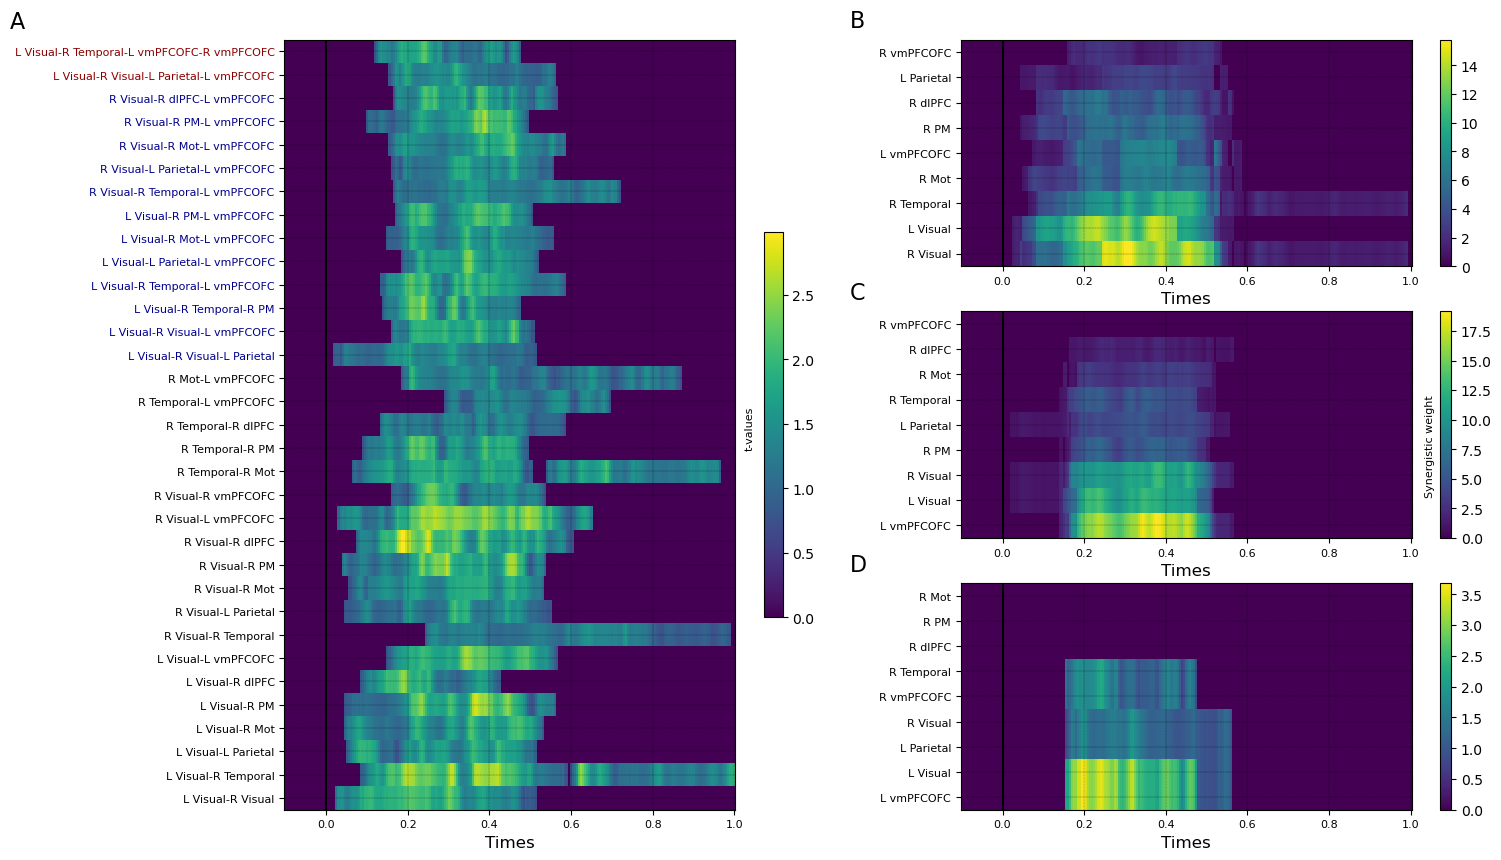

In [50]:
# Plot figure with subplots of different sizes
fig = plt.figure(1, figsize=(16, 10))
# Use gridspec to partition the figure into subplots
gridspec.GridSpec(3,2)
# Get axes object
ax = plt.subplot2grid((3,2), (0,0), rowspan=3, colspan=1)
# Plot heatmap
plt.pcolormesh(
    df.columns, df.index, df.values, cmap='viridis', shading='auto',
)
plt.xlabel('Times', fontsize=12)
# set xtick label fontsize to 8
plt.xticks(fontsize=8)
plt.axvline(0., color='k')

# Set the color of the ylabel to red for the first 10 labels
for i, t in enumerate(ax.get_yticklabels()):
    if order[i] == 2:
        t.set_color('k')
    elif order[i] == 3:
        t.set_color('darkblue')
    else :
        t.set_color('darkred')


# Set the ylabels font to bold 
ax.set_yticklabels(ax.get_yticklabels(), fontweight='normal', fontsize=8)
# legend
plt.colorbar(shrink=0.5)
# Reduce the width of the colorbar
# Add the legend of the colorbar
plt.text(1.025, 15., 't-values', fontsize=8, rotation=90)
# cbar.ax.set_position([-.2, -0.05, .01, .6])
# Set the label of the colorbar on top of the colorbar

# remove underscores from ylabels 
ax.set_yticklabels([i.replace('_', ' ') for i in df.index])
# add grid dotted
plt.grid(True, linestyle='--', linewidth=0.2)

# Add subplot label
ax.text(-0.775, 33, 'A', fontsize=16)

#-----------------------------------------------
# Analysis of temporal hypergraph representation
#-----------------------------------------------
# ROI labels
list_rois = ['L_Visual', 'R_Visual', 'L_Parietal', 'R_Temporal', 'R_Mot', 'R_PM', 'R_dlPFC' , 'L_vmPFCOFC','R_vmPFCOFC']
# Short ROIS labels
list_rois_short = ['L Vis', 'R Vis', 'L Par', 'R Temp', 'R Mot', 'R PM', 'R dlPFC' , 'L vmOFC','R vmOFC']
# Titles
titles = ['Pairs', 'Triplets', 'Quadruplets']
subplot_label = ['B', 'C', 'D']
# Get only a specific order of the edges hypergraph
# Loop over orders
for k, o in enumerate(np.unique(order)):
    # Find the indices of the edges at a specific order
    ind_order = np.where(data.links.order == o)[0]
    # Select the data at a specific order
    data_order = data[ind_order]
    # Define roi weight vector for all time points
    weights = np.zeros((len(list_rois), data_order.shape[1]))
    # Loop over time points
    for t in range(data_order.shape[1]):
        # Get the indices of the edges that are active at time t
        ind = np.where(data_order.values[:, t] > 0)[0]
        # If there are no active edges, skip this time point
        if len(ind) == 0:
            continue
        # Get the labels of the active hyperedges
        labels = data_order.links[ind]
        for n, roi in enumerate(list_rois):
            # Find the indices of the edges that contain the ROI
            ind_edge = np.where([roi in j for j in labels.links.data])[0]
            # If the roi is not part of the edge, skip this roi
            if len(ind_edge) == 0:
                continue
            # Get the weights of the active hyperedges
            weights[n, t] = data_order.values[ind_edge, t].sum()
            # Get the labels of the active hyperedges


    # Get axes object
    ax = plt.subplot2grid((3,2), (k, 1), rowspan=1, colspan=1)
    # Sort weights by values
    ind_sort = np.argsort(weights.sum(axis=1))
    weights = weights[ind_sort,:]
    # plot the weights with pcolormesh
    plt.pcolormesh(data_order.times, range(len(list_rois)), weights, shading='auto')
    # add xlabel only the last subplot
    plt.xlabel('Times', fontsize=12)
    # make colormap
    plt.set_cmap('viridis')
    # Add colorbar
    plt.colorbar()
    # set xtick label fontsize to 8
    plt.xticks(fontsize=8)
    # Add yticks only the first subplot
    # remove "_" from yticklabels
    list_rois_ = [i.replace('_', ' ') for i in list_rois]
    # Sort list_rois_ according to ind_sort
    list_rois_ = [list_rois_[i] for i in ind_sort]
    # Replace list_rois_ with list_rois_short
    # list_rois_ = list_rois_short
    plt.yticks(range(len(list_rois_)), list_rois_, fontsize=8)
    # invert order of yticklabels
    plt.gca().invert_yaxis()
    # add zero line
    plt.axvline(0., color='k')
    # Add text vertically to the left of the subplot
    # plt.ylabel(titles[k], fontsize=12, rotation=90, labelpad=8)
    # add dotted grid
    plt.grid(True, linestyle='--', linewidth=0.2)

    # Add subplot label that changes with the order
    ax.text(-0.375, -1, subplot_label[k], fontsize=16)

# Add the legend of the colorbar
plt.text(1.035, -4., 'Synergistic weight', fontsize=8, rotation=90)

In [58]:
# Compute the number of significant links at order 2
order = data.links.order
order_2 = np.where(order == 2)[0]
order_3 = np.where(order == 3)[0]
order_4 = np.where(order == 4)[0]
# Number of links pairwise from 9 nodes
nlinks = 9 * 8 // 2
# Number of triplets from 9 nodes
ntriplets = 9 * 8 * 7 // 6
# Number of quadruplets from 9 nodes
nquadruplets = 9 * 8 * 7 * 6 // 24
# print the percentage of significant links at all orders
print('Percentage of significant links at order 2: {0:.2f}%'.format(100 * len(order_2) / nlinks))
print('Percentage of significant links at order 3: {0:.2f}%'.format(100 * len(order_3) / ntriplets))
print('Percentage of significant links at order 4: {0:.2f}%'.format(100 * len(order_4) / nquadruplets))
# print the numer of significant links at all orders
print('Number of significant links at order 2: {0}'.format(len(order_2)))
print('Number of significant links at order 3: {0}'.format(len(order_3)))
print('Number of significant links at order 4: {0}'.format(len(order_4)))   


Percentage of significant links at order 2: 52.78%
Percentage of significant links at order 3: 14.29%
Percentage of significant links at order 4: 1.59%
Number of significant links at order 2: 19
Number of significant links at order 3: 12
Number of significant links at order 4: 2


In [10]:
fig.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_6.png', dpi=300, bbox_inches='tight')

## Figure 4 bis. Higher-order redundancy with Bayesian surprise

Load data and parameters

In [60]:
# Load data
fname = Results_Dir + '{0}_{1}_{2}_{3}_red_minorder2.nc'.format(event, mi_reg, mi_type, mcp)
ds = xr.load_dataset(fname)

# Thresholded data
# data = ds.hoi  * (ds.pv <= 0.05)
data = ds.tv * (ds.pv <= 0.05)
data_sign = ds.tv  * (ds.pv <= 0.05)

# Select time interval
data = data.sel(times=slice(-0.1, 1.))

# Select link with non zero entries in the matrix
data = data.sel(links=data_sign.links[data_sign.sum('times') != 0])

# Calculate the order of each link (multiplet)
# (i.e. the number of '-' in the label of the two nodes of the link)
labels = data['links']
order = [len([c for c in s if c == '-']) for s in labels.values]
# adde 1 to the order to avoid 0
order = np.array(order) + 1
order = np.array(order)
# add dimension with the valuers of order to the dataframe
data['order'] = ('links', order)

# Tranform to dataframe
data = data.T
df = data.to_pandas()

FileNotFoundError: [Errno 2] No such file or directory: b'/hpc/brainets/data/db_mne/meg_te/group/outcome_bayes_surprise_cc_cluster_red_minorder2.nc'

/tmp/ipykernel_21297/4042547064.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='normal', fontsize=8)
/tmp/ipykernel_21297/4042547064.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([i.replace('_', ' ') for i in df.index])


IndexError: GridSpec slice would result in no space allocated for subplot

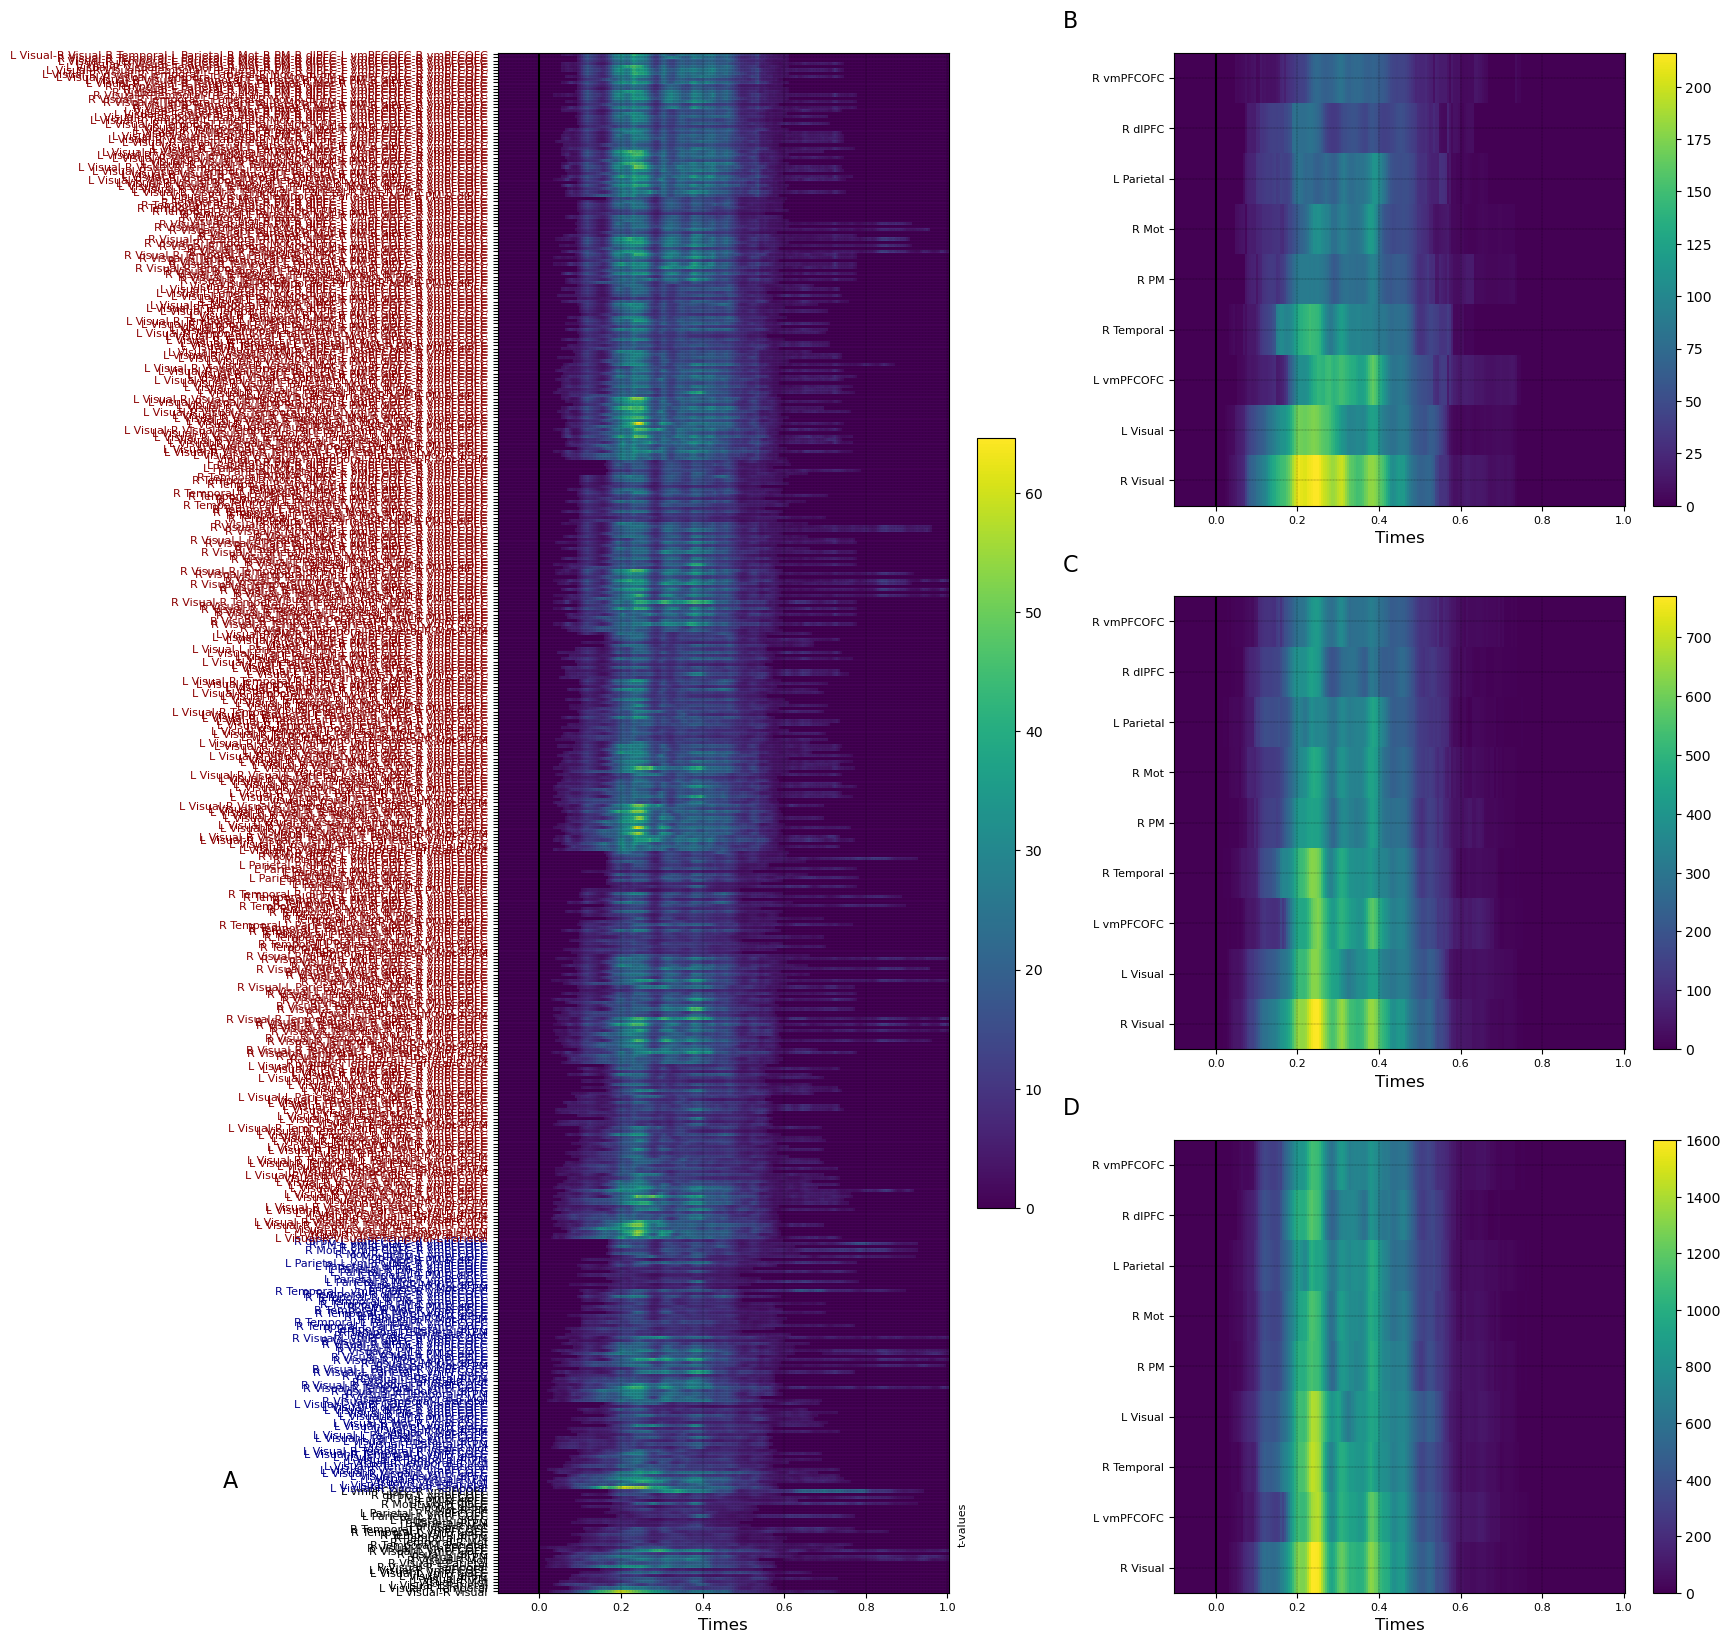

In [34]:
# Plot figure with subplots of different sizes
fig = plt.figure(1, figsize=(16, 20))
# Use gridspec to partition the figure into subplots
gridspec.GridSpec(3,2)
# Get axes object
ax = plt.subplot2grid((3,2), (0,0), rowspan=3, colspan=1)
# Plot heatmap
plt.pcolormesh(
    df.columns, df.index, df.values, cmap='viridis', shading='auto',
)
plt.xlabel('Times', fontsize=12)
# set xtick label fontsize to 8
plt.xticks(fontsize=8)
plt.axvline(0., color='k')

# Set the color of the ylabel to red for the first 10 labels
for i, t in enumerate(ax.get_yticklabels()):
    if order[i] == 2:
        t.set_color('k')
    elif order[i] == 3:
        t.set_color('darkblue')
    else :
        t.set_color('darkred')


# Set the ylabels font to bold 
ax.set_yticklabels(ax.get_yticklabels(), fontweight='normal', fontsize=8)
# legend
plt.colorbar(shrink=0.5)
# Reduce the width of the colorbar
# Add the legend of the colorbar
plt.text(1.025, 15., 't-values', fontsize=8, rotation=90)
# cbar.ax.set_position([-.2, -0.05, .01, .6])
# Set the label of the colorbar on top of the colorbar

# remove underscores from ylabels 
ax.set_yticklabels([i.replace('_', ' ') for i in df.index])
# add grid dotted
plt.grid(True, linestyle='--', linewidth=0.2)

# Add subplot label
ax.text(-0.775, 33, 'A', fontsize=16)

#-----------------------------------------------
# Analysis of temporal hypergraph representation
#-----------------------------------------------
# ROI labels
list_rois = ['L_Visual', 'R_Visual', 'L_Parietal', 'R_Temporal', 'R_Mot', 'R_PM', 'R_dlPFC' , 'L_vmPFCOFC','R_vmPFCOFC']
# Short ROIS labels
list_rois_short = ['L Vis', 'R Vis', 'L Par', 'R Temp', 'R Mot', 'R PM', 'R dlPFC' , 'L vmOFC','R vmOFC']
# Titles
titles = ['Pairs', 'Triplets', 'Quadruplets']
subplot_label = ['B', 'C', 'D']
# Get only a specific order of the edges hypergraph
# Loop over orders
for k, o in enumerate(np.unique(order)):
    # Find the indices of the edges at a specific order
    ind_order = np.where(data.links.order == o)[0]
    # Select the data at a specific order
    data_order = data[ind_order]
    # Define roi weight vector for all time points
    weights = np.zeros((len(list_rois), data_order.shape[1]))
    # Loop over time points
    for t in range(data_order.shape[1]):
        # Get the indices of the edges that are active at time t
        ind = np.where(data_order.values[:, t] > 0)[0]
        # If there are no active edges, skip this time point
        if len(ind) == 0:
            continue
        # Get the labels of the active hyperedges
        labels = data_order.links[ind]
        for n, roi in enumerate(list_rois):
            # Find the indices of the edges that contain the ROI
            ind_edge = np.where([roi in j for j in labels.links.data])[0]
            # If the roi is not part of the edge, skip this roi
            if len(ind_edge) == 0:
                continue
            # Get the weights of the active hyperedges
            weights[n, t] = data_order.values[ind_edge, t].sum()
            # Get the labels of the active hyperedges


    # Get axes object
    ax = plt.subplot2grid((3,2), (k, 1), rowspan=1, colspan=1)
    # Sort weights by values
    ind_sort = np.argsort(weights.sum(axis=1))
    weights = weights[ind_sort,:]
    # plot the weights with pcolormesh
    plt.pcolormesh(data_order.times, range(len(list_rois)), weights, shading='auto')
    # add xlabel only the last subplot
    plt.xlabel('Times', fontsize=12)
    # make colormap
    plt.set_cmap('viridis')
    # Add colorbar
    plt.colorbar()
    # set xtick label fontsize to 8
    plt.xticks(fontsize=8)
    # Add yticks only the first subplot
    # remove "_" from yticklabels
    list_rois_ = [i.replace('_', ' ') for i in list_rois]
    # Sort list_rois_ according to ind_sort
    list_rois_ = [list_rois_[i] for i in ind_sort]
    # Replace list_rois_ with list_rois_short
    # list_rois_ = list_rois_short
    plt.yticks(range(len(list_rois_)), list_rois_, fontsize=8)
    # invert order of yticklabels
    plt.gca().invert_yaxis()
    # add zero line
    plt.axvline(0., color='k')
    # Add text vertically to the left of the subplot
    # plt.ylabel(titles[k], fontsize=12, rotation=90, labelpad=8)
    # add dotted grid
    plt.grid(True, linestyle='--', linewidth=0.2)

    # Add subplot label that changes with the order
    ax.text(-0.375, -1, subplot_label[k], fontsize=16)

# Add the legend of the colorbar
plt.text(1.035, -4., 'Redundancy weight', fontsize=8, rotation=90)

### Feature-specfic Information Transfer encoding Bayesian surprise


Text(1.03, 1, 'FIT (bits)')

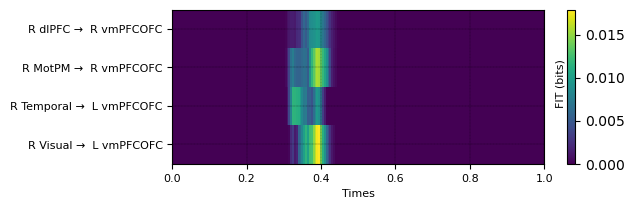

In [8]:
fname = Results_Dir + '{0}_{1}_{2}_{3}_fit_rois.nc'.format(event, mi_reg, mi_type, mcp)
ds = xr.load_dataset(fname)

# Create thresholded FC matrix
da = ds.fit * (ds.pv <= 0.05)

# Rename dim links
# da = da.rename({'links': 'roi'})

# Select time interval
da = da.sel(times=slice(-0.1, 1.))

# Plot heatmap of the pairs of brain regions showing significant values different from 0
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
# Select the links with non zero values
da = da.sel(links=da.links[da.sum('times') != 0])
plt.pcolormesh(
    da.times, da.links, da.T, cmap='viridis', shading='auto',
)
# Add colorbar
plt.colorbar()
# Set xlim to -0.1 to 1.0   
plt.xlim(0., 1.0)

# add zero line
plt.axvline(0., color='k')
# Add text vertically to the left of the subplot
# plt.ylabel(titles[k], fontsize=12, rotation=90, labelpad=8)
# add dotted grid
plt.grid(True, linestyle='--', linewidth=0.2)


# Replace "->" with an arrow symbol
labels = da.links.values
labels = [i.replace('->', ' →  ') for i in labels]
# remove "_" from yticklabels
labels = [i.replace('_', ' ') for i in labels]
# Set the yticklabels
plt.yticks(range(len(labels)), labels, fontsize=8)
# Set the xticklabels
plt.xticks(fontsize=8)
# Add xlabel
plt.xlabel('Times', fontsize=8)
# Add the legend of the colorbar

# Add the legend of the colorbar
plt.text(1.03, 1, 'FIT (bits)', fontsize=8, rotation=90)

# # Set colorscale from 0 to 1.5
# plt.clim(0, 1.2)


In [56]:
fig.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_8.png', dpi=300, bbox_inches='tight')

### Local versus global synergy encoding of Bayesian surprise


(-0.1, 1.0)

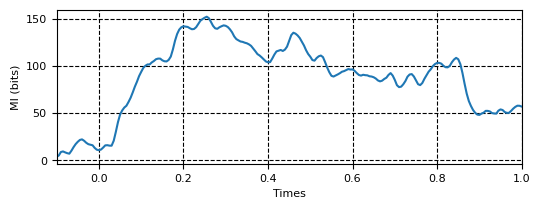

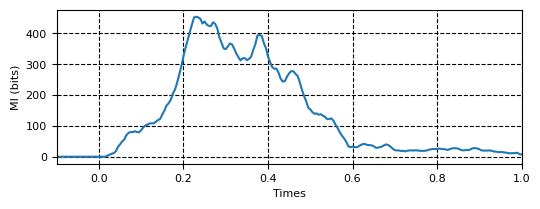

In [59]:
# Plot the sum of gcmi across all ROIs over time
local_encoding = gcmi_tval.sum('roi')
local_encoding = local_encoding.sel(times=slice(-0.1, 1.))
# plot local_encoding
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
plt.plot(local_encoding.times, local_encoding.values)
plt.xlabel('Times', fontsize=8)
plt.ylabel('MI (bits)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
# xlim to -0.1 to 1.0
plt.xlim(-0.1, 1.0)

# Compute the sum of all synergistic encoding
synergistic_encoding = data_mi.sum('links')
synergistic_encoding = synergistic_encoding.sel(times=slice(-0.1, 1.))
# plot synergistic_encoding
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
plt.plot(synergistic_encoding.times, synergistic_encoding.values)
plt.xlabel('Times', fontsize=8)
plt.ylabel('MI (bits)', fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(True)
plt.xlim(-0.1, 1.0)

# 
# fig.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_9.png', dpi=300, bbox_inches='tight')


### Granger causality analyses across orders


In [108]:
# Load data
fname = Results_Dir + '{0}_{1}_{2}_{3}_syn_minorder2.nc'.format(event, mi_reg, mi_type, mcp)
ds = xr.load_dataset(fname)

# Thresholded data
data = ds.hoi  * (ds.pv <= 0.05)
# data = ds.tv

# Select time interval
data = data.sel(times=slice(-0.1, 1.))

# Select link with non zero entries in the matrix
data = data.sel(links=data_sign.links[data_sign.sum('times') != 0])

# Calculate the order of each link (multiplet)
# (i.e. the number of '-' in the label of the two nodes of the link)
labels = data['links']
order = [len([c for c in s if c == '-']) for s in labels.values]
# adde 1 to the order to avoid 0
order = np.array(order) + 1
order = np.array(order)
# add dimension with the valuers of order to the dataframe
data['order'] = ('links', order)

# Tranform to dataframe
data = data.T
df = data.to_pandas()

In [109]:
from frites.conn import (conn_covgc, conn_reshape_directed,
                         conn_reshape_undirected)
# Compute granger causality measures bewteen the time series using conn_covgc
t0 = 10
lag = 20
dt = 200
x = df.values
# add a first empty dimension
x = np.expand_dims(x, axis=0)
times = df.columns
links = df.index
# replace the '-' by '_' in the labels in the links variable
links = [i.replace('-', ',') for i in links]
# Compute the order of each link, which is the number of ',' in the label + 1
order = [len([c for c in s if c == ',']) for s in links]
order = np.array(order) + 1
# compute covGC
gc = conn_covgc(x, dt, lag, t0, times=times, roi=links)


Defining links (n_roi=33; directed=False; net=False, nb_min_links=None)
Compute the  covgc (method=gc, normalised=False, n_pairs=528; n_windows=1, lag=20, dt=200, step=1)


  0%|          |  : 0/528 [00:00<?,       ?it/s]

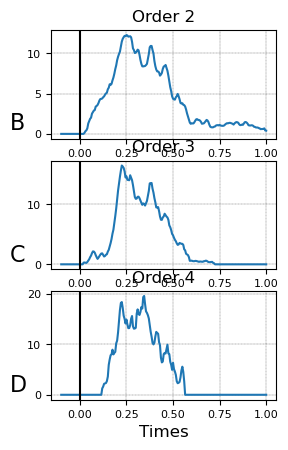

In [116]:
# plot df data as time series and compute the average time course at each order
# Get the average time course at each order
# Loop over orders
for k, o in enumerate(np.unique(order)):
    # Find the indices of the edges at a specific order
    ind_order = np.where(order == o)[0]
    # Select the data at a specific order in x
    x_order = x[:, ind_order, :]
    # Compute the average time course
    x_order = x_order.mean(axis=1)
    # Get axes object
    ax = plt.subplot2grid((3,2), (k, 0), rowspan=1, colspan=1)
    # plot the average time course
    plt.plot(times, x_order.T)
    # add xlabel only the last subplot
    plt.xlabel('Times', fontsize=12)
    # add ylabel only the first subplot
    plt.ylabel('', fontsize=12)
    # add title
    plt.title('Order ' + str(o), fontsize=12)
    # add zero line
    plt.axvline(0., color='k')
    # add dotted grid
    plt.grid(True, linestyle='--', linewidth=0.2)
    # set xtick label fontsize to 8
    plt.xticks(fontsize=8)
    # set ytick label fontsize to 8
    plt.yticks(fontsize=8)
    # Add subplot label that changes with the order
    ax.text(-0.375, 0.5, subplot_label[k], fontsize=16)
    

In [112]:
# calculate the mean of the gc for each pair of ROIs averaged according to the order
# Loop over orders
for k, o in enumerate(np.unique(order)):
    for j, oo in enumerate(np.unique(order)):
        # Compute the average of the data for each pair of order
        ind_k = np.where(order == o)[0]
        ind_j = np.where(order == oo)[0]
        # Select the data at a specific order
        data_order = gc.iloc[ind_k, ind_j]
        # Compute the average of the data at a specific order
        data_order = data_order.mean(axis=0)
        # store in a adjacency matrix
        if k == 0 and j == 0:
            gc_o = np.zeros((len(np.unique(order)), len(np.unique(order))))
        gc_o[k, j] = data_order.mean()

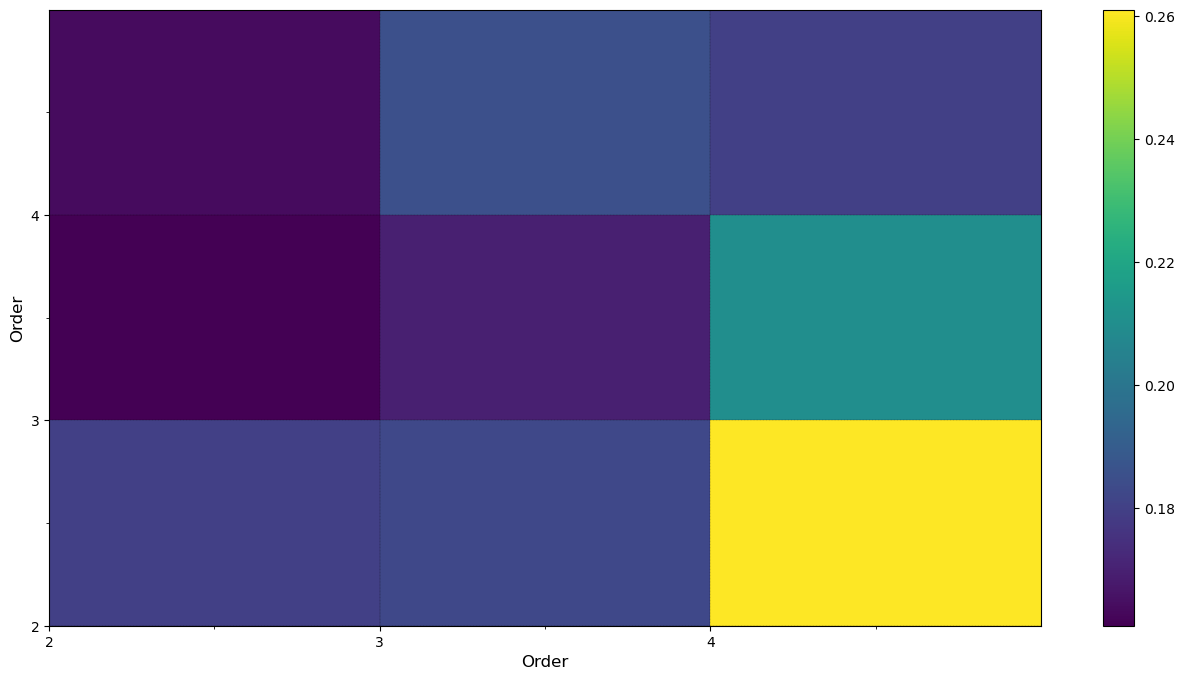

In [113]:
# plot the gc_o as a adjacnecy mtraix with oder as labels
fig = plt.figure(1, figsize=(16, 8))
# plot data as a adjacency matrix
plt.pcolormesh(gc_o, cmap='viridis', shading='auto')
# add xlabel
plt.xlabel('Order', fontsize=12)
# add ylabel
plt.ylabel('Order', fontsize=12)
# add xticks as order values
plt.xticks(range(len(np.unique(order))), np.unique(order))  
# add yticks as order values
plt.yticks(range(len(np.unique(order))), np.unique(order))
# add tick and label in the middle of the cell
plt.gca().set_xticks(np.arange(len(np.unique(order))) + 0.5, minor=True)
plt.gca().set_yticks(np.arange(len(np.unique(order))) + 0.5, minor=True)
# add grid
plt.grid(True, linestyle='--', linewidth=0.2)
# add colorbar
plt.colorbar()
# add title





In [ ]:
# plot the time course of the data for each order
fig = plt.figure(1, figsize=(16, 8))
# loop over orders
for k, o in enumerate(np.unique(order)):
    # get the indices of the data at a specific order
    ind = np.where(order == o)[0]
    # Select the data at a specific order
    data_order = gc.iloc[ind, ind]
    # plot the data
    plt.plot(data_order.mean(axis=0), label=o)
